# Modelos Econométricos
Neste notebook tem os seguintes modelos estatísticos:
- AR
- ARIMA
- SARIMA

## Importações

In [109]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# autoarima
import pmdarima as pm

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import itertools
import os

## Preparação do Diretório Principal

In [110]:
def prepare_directory_work(end_directory: str='notebooks'):
    # Current path
    curr_dir = os.path.dirname(os.path.realpath("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return curr_dir
    
    return f'Current working directory: {curr_dir}' 

In [111]:
prepare_directory_work(end_directory='notebooks')

'Current working directory: /home/campos/projects/tcc-ufsc-grad'

## Formatação das células

In [112]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# Guarantees visualization inside the jupyter
%matplotlib inline

# Print xxxx rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# pretty print
pp = pprint.PrettyPrinter(indent=4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

## Carregamento dos dados

In [114]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                              encoding='utf8',
                              delimiter=',',
                              parse_dates=True,
                              index_col=0,
                              verbose=True)

Tokenization took: 2.64 ms
Type conversion took: 3.50 ms
Parser memory cleanup took: 0.01 ms
CPU times: user 10.3 ms, sys: 2.95 ms, total: 13.3 ms
Wall time: 18.4 ms


In [115]:
df_vale3.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.000000,1.002310,41.827333,1.000149,-0.600000,-0.460000,0.490000,0.980000,0.420000
2010-07-13,40.070000,1.036654,41.910833,0.998563,0.070000,-0.530000,-0.390000,0.560000,1.050000
2010-07-14,40.080000,1.028377,41.977833,1.000439,0.010000,0.080000,-0.520000,-0.380000,0.570000
2010-07-15,39.760000,1.044658,42.045833,1.000935,-0.320000,-0.310000,-0.240000,-0.840000,-0.700000
2010-07-16,38.880000,1.028132,42.123500,1.001784,-0.880000,-1.200000,-1.190000,-1.120000,-1.720000


---

## Divisão dos Dados

In [116]:
size_train = 2355
size_test = 90
print(size_train)
print(size_test)

df_train = df_vale3['preco'].iloc[:size_train]
df_test = df_vale3['preco'].iloc[size_train:]

2355
90


In [117]:
df_train.tail()

data
2020-01-10   53.360000
2020-01-13   55.300000
2020-01-14   55.640000
2020-01-15   55.460000
2020-01-16   55.170000
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Treinamento = 2355')

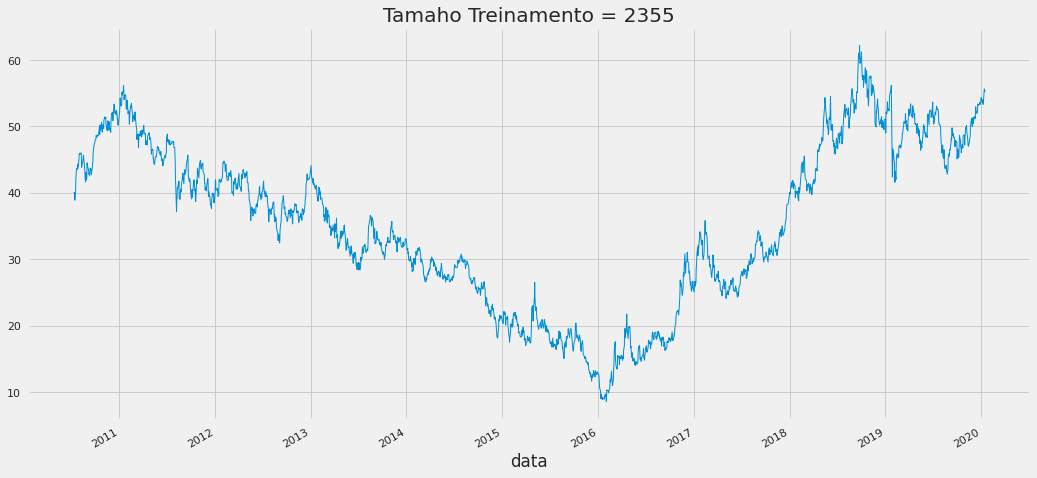

In [118]:
df_train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Treinamento = {len(df_train)}')

In [119]:
df_test.head()

data
2020-01-17   57.000000
2020-01-20   57.360000
2020-01-21   56.030000
2020-01-22   56.300000
2020-01-23   55.500000
Name: preco, dtype: float64

Text(0.5, 1.0, 'Tamaho Teste = 90')

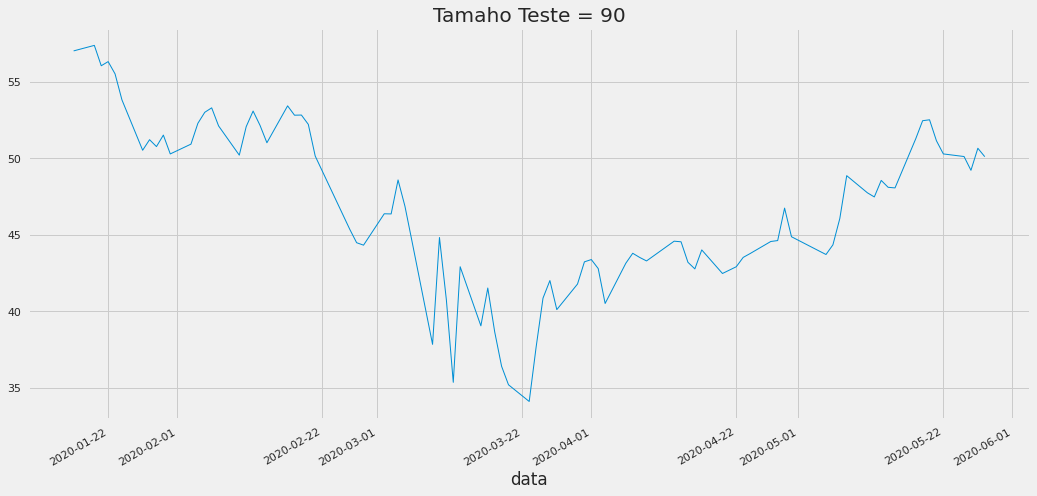

In [120]:
df_test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Tamaho Teste = {len(df_test)}')

### Manipulação do índice

In [121]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16'],
              dtype='datetime64[ns]', name='data', length=2355, freq=None)

In [122]:
df_test.index

DatetimeIndex(['2020-01-17', '2020-01-20', '2020-01-21', '2020-01-22',
               '2020-01-23', '2020-01-24', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-03',
               '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-17', '2020-02-18', '2020-02-19',
               '2020-02-20', '2020-02-21', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-06', '2020-04-07',
      

In [123]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=2355, step=1)

In [124]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=90, step=1)

In [125]:
df_train.index = pd.RangeIndex(start=0, stop=len(df_train), step=1)
df_train.index

RangeIndex(start=0, stop=2355, step=1)

In [126]:
df_test.index = pd.RangeIndex(start=2355, stop=len(df_vale3), step=1)
df_test.index

RangeIndex(start=2355, stop=2445, step=1)

---

## Dicionário de Resultados

In [127]:
dict_results = {}

---

## Impressão dos Resutados

In [129]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    #mape = mean_absolute_percentage_error(df_test, y_forecast)
    mape = mean_absolute_percentage_error(df_test, y_forecast)*100
    
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

---

## Busca dos Melhores Parâmetros

#### Grid Search

In [130]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0, 3)

# Generate all different combinations of p, q and q triplets
list_pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {list_pdq}')

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [131]:
def search_best_params_arima_model(df_train: 'Dataframe', pdq: list) -> list:
    best_model = 99999
    best_params = (0, 0, 0)
    param = ()
    
    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')
            
            if results.aic < best_model:
                best_model = results.aic
                best_params = param
        except: 
            continue
    
    print(f'best ARIMA: {best_params} | AIC:{best_model}')
    return [best_params, best_model]

In [132]:
def search_best_params_sarima_model(df_train, trend, pdq):  
    best_model = 99999
    best_param_seasonal = ()
    param = ()
    param_seasonal = ()
    
    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,          
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_param_seasonal = param_seasonal
        except: 
            continue
    
    print(f'\n\nBest SARIMA: {pdq}x{param_seasonal}12 | AIC:{best_model}')
    return [best_param_seasonal, best_model]

---

## **Modelos Estatísticos**

## AR
- A ST não é estacionária
- Não há tendência, (trend='n')
- Não aá sazonalidade, (seasonal=False) no período de 30 dias

In [133]:
ar_model = AutoReg(df_train,
                   lags=200,
                   trend='n',
                   seasonal=False,
                   period=len(df_test))
ar_fit = ar_model.fit()

In [134]:
# forecast
y_ar_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

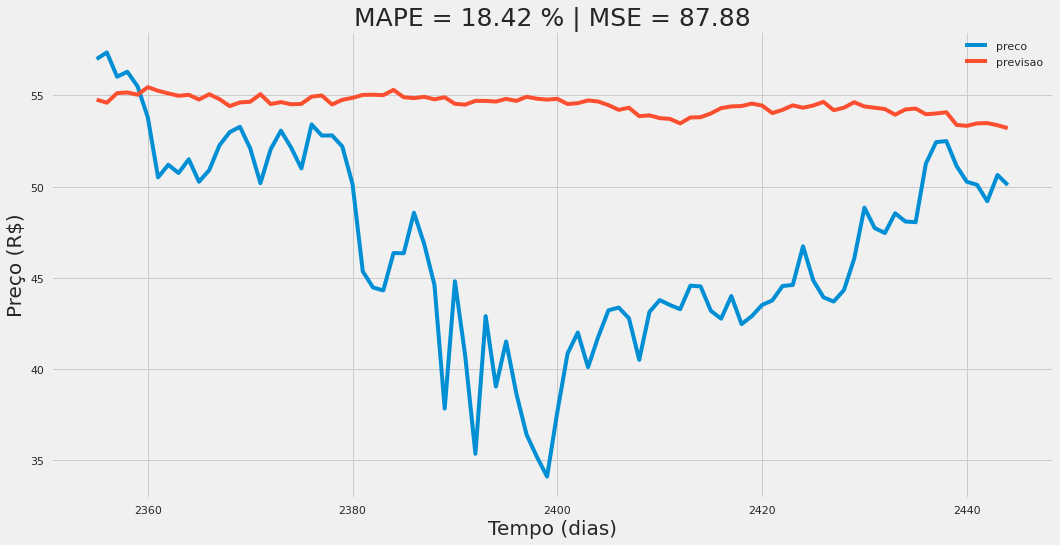

In [138]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

#### zoom

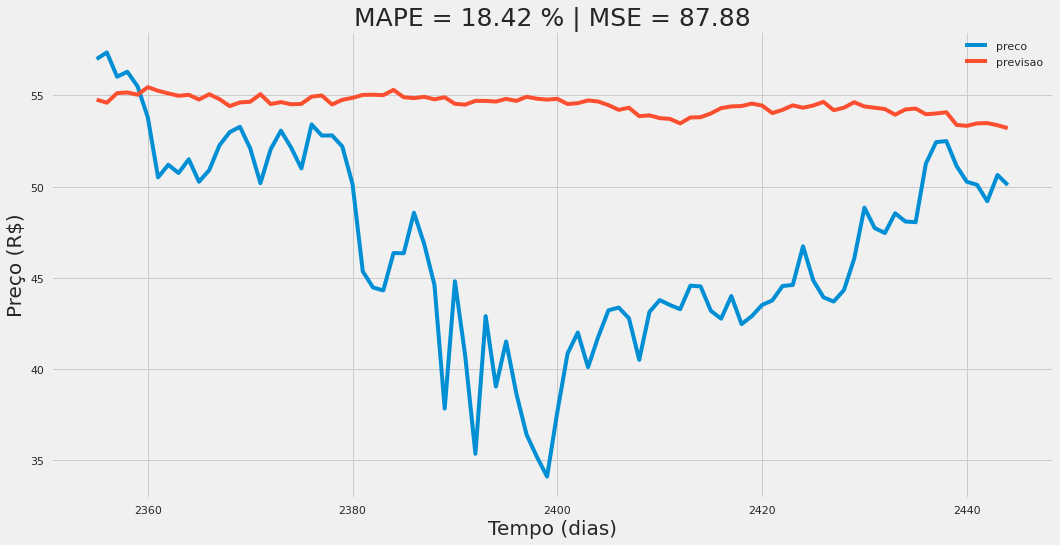

In [139]:
show_result_model(df_train=df_test,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

---

### ARIMA

## Librarie: `pmdarima`
- Tips: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [140]:
%%time

list_order_arima = search_best_params_arima_model(df_train=df_train,
                                                  pdq=list_pdq)
print(list_order_arima)

pdq = (0, 0, 0) | AIC = 18496.807076058874
pdq = (0, 0, 1) | AIC = 15433.19910484433
pdq = (0, 1, 0) | AIC = 5761.623702244484
pdq = (0, 1, 1) | AIC = 5763.254613137087
pdq = (0, 1, 2) | AIC = 5751.100625599235
pdq = (0, 2, 0) | AIC = 7363.761142679766
pdq = (0, 2, 1) | AIC = 5768.777955653926
pdq = (0, 2, 2) | AIC = 5770.412744135856
pdq = (1, 0, 0) | AIC = 5769.095932374262
pdq = (1, 0, 1) | AIC = 5770.652804407208
pdq = (1, 0, 2) | AIC = 5758.919742576081
pdq = (1, 1, 0) | AIC = 5763.310049395428
pdq = (1, 1, 1) | AIC = 5757.341435194941
pdq = (1, 1, 2) | AIC = 5753.094844273129
pdq = (1, 2, 0) | AIC = 6816.901833322252
pdq = (1, 2, 2) | AIC = 5764.522694014011
pdq = (2, 0, 0) | AIC = 5770.718575117545
pdq = (2, 0, 1) | AIC = 5764.698257037379
pdq = (2, 0, 2) | AIC = 5760.883422505614
pdq = (2, 1, 0) | AIC = 5751.982431329203
pdq = (2, 1, 1) | AIC = 5753.895888629764
pdq = (2, 1, 2) | AIC = 5750.69244506511
pdq = (2, 2, 0) | AIC = 6479.286056999536
pdq = (2, 2, 1) | AIC = 5759.10105

In [141]:
%%time

autoarima_model = pm.auto_arima(df_train,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                information_criterion='aic',
                                start_p=3,
                                start_d=1,
                                start_q=2,
                                max_p=10,
                                max_d=10,
                                max_q=10,
                                lags=200,
                                # trend=False,
                                seasonal=False,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5751.563, Time=2.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5761.624, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5763.310, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5763.255, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5759.768, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5750.693, Time=3.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5753.109, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5753.896, Time=1.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5751.482, Time=3.87 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5757.341, Time=0.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5754.072, Time=1.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5754.468, Time=1.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5753.427, Time=3.96 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5748.920, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [142]:
print(autoarima_model.order)
print(autoarima_model.aic())

(2, 1, 2)
5748.920103235651


In [143]:
# fit
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [144]:
# forecast
y_forecast = autoarima_model_fit.predict(n_periods=len(df_test[:90]))
len(y_forecast)

90

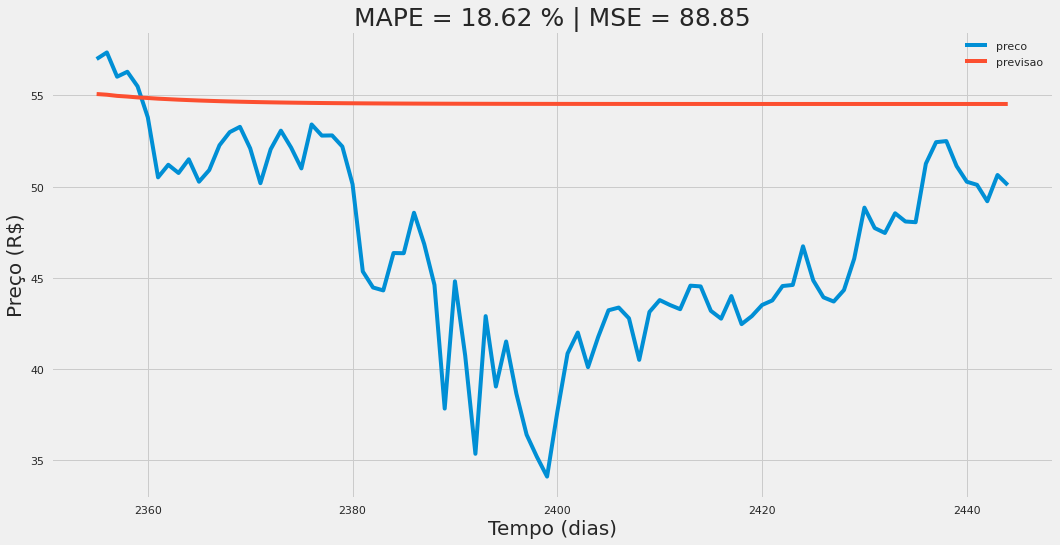

In [145]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model')

#### Zoom

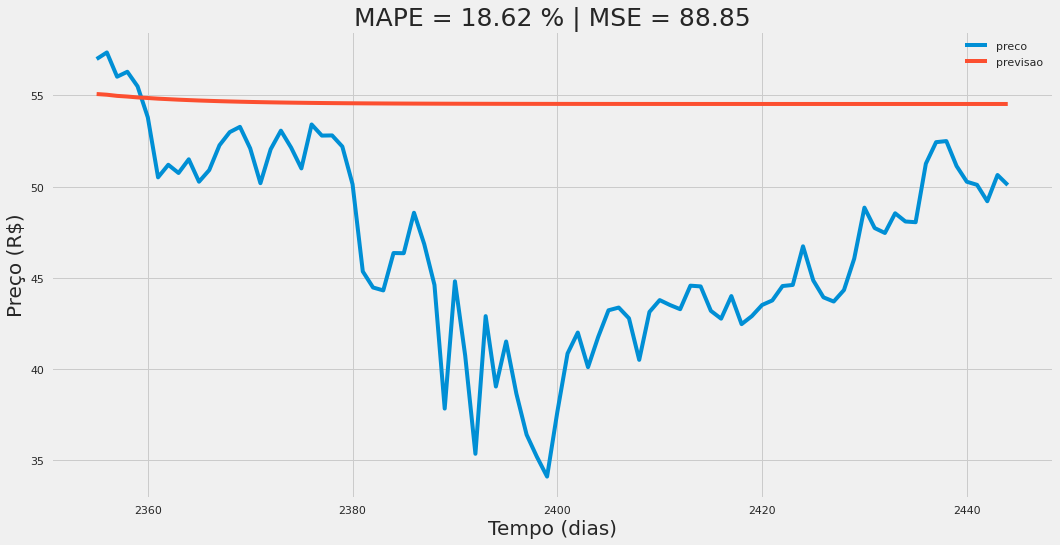

In [146]:
show_result_model(df_train=df_test,
                  df_test=df_test, 
                  y_forecast=y_forecast,
                  model_name='arima_model')

---

## **SARIMA**

In [147]:
%%time

list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train,
                                                          trend='t',
                                                          pdq=(3, 1, 3))
print(list_order_seasonal_aic)

pdq = (3, 1, 3) | param_seasonal = (0, 0, 0, 12) | AIC = 5756.413585440967
pdq = (3, 1, 3) | param_seasonal = (0, 0, 1, 12) | AIC = 5757.012677521172
pdq = (3, 1, 3) | param_seasonal = (0, 0, 2, 12) | AIC = 5756.468183243522
pdq = (3, 1, 3) | param_seasonal = (0, 1, 0, 12) | AIC = 7408.032885290173
pdq = (3, 1, 3) | param_seasonal = (0, 1, 1, 12) | AIC = 6410.607479509123
pdq = (3, 1, 3) | param_seasonal = (0, 1, 2, 12) | AIC = 6309.743968387311
pdq = (3, 1, 3) | param_seasonal = (0, 2, 0, 12) | AIC = 9930.080684410583
pdq = (3, 1, 3) | param_seasonal = (0, 2, 1, 12) | AIC = 9054.926557874096
pdq = (3, 1, 3) | param_seasonal = (0, 2, 2, 12) | AIC = 8260.058234322574
pdq = (3, 1, 3) | param_seasonal = (1, 0, 0, 12) | AIC = 5757.048469007777
pdq = (3, 1, 3) | param_seasonal = (1, 0, 1, 12) | AIC = 5756.880962409094
pdq = (3, 1, 3) | param_seasonal = (1, 0, 2, 12) | AIC = 5757.124397067047
pdq = (3, 1, 3) | param_seasonal = (1, 1, 0, 12) | AIC = 6837.126300272923
pdq = (3, 1, 3) | param_s

In [148]:
list_order_seasonal_aic

[(0, 0, 0, 12), 5756.413585440967]

In [149]:
sarima_model = SARIMAX(df_train,
                       order=(6, 2, 6),
                       seasonal_order=list_order_seasonal_aic[0],
                       trend='c',          
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [150]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

In [151]:

# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1]).to_numpy()
len(y_forecast_sarima)

90

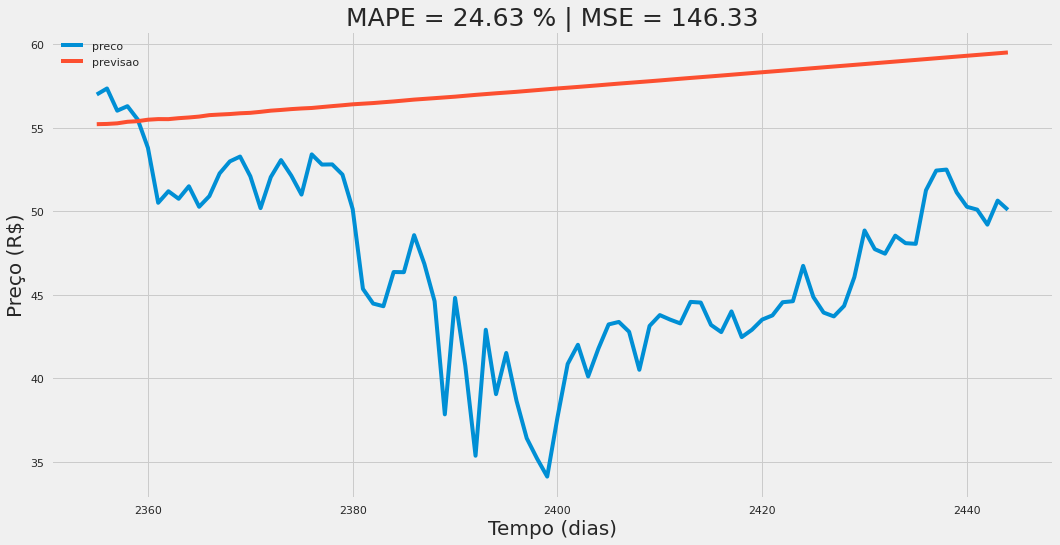

In [152]:
show_result_model(df_train=df_test,
                  df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model')

---

## Resultados

In [153]:
dict_results

{'ar_model': [18.41842333993979, 87.88155069540156],
 'arima_model': [18.624479720163134, 88.84919302760932],
 'sarima_model': [24.6304560917296, 146.33215805142635]}

---